<a href="https://colab.research.google.com/github/vandanachandola/Smart-Home-Dataset-With-Weather-Information/blob/main/Smart_Home_Dataset_with_Weather_Information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smart Home Dataset with Weather Information

**Table Of Contents**
1. Data Pre-processing
2. Data Transformation
3. Data Visualization
4. Correlation between features
5. Autocorrelation
6. Time Series Analysis
7. Anomaly Detection
8. Time Series Forecasting

In [92]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose


## Part 1 - Data Pre-processing

**Import CSV file from Google Drive.**

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
home_df = pd.read_csv('/content/gdrive/Shared drives/CMPE 255 - Team Stormtroopers/HomeC.csv')
home_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [5]:
home_df.tail(5)

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
503906,1452128306,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,0.000100,0.000033,0.032200,0.00095,0.003800,0.000933,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503907,1452128307,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,0.000067,0.000000,0.032283,0.00100,0.003750,0.001000,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503908,1452128308,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,0.000117,0.000017,0.032183,0.00095,0.003767,0.000950,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503909,1452128309,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,0.000517,0.000117,0.000017,0.032167,0.00095,0.003767,0.000950,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503910,\,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Remove the last row that contains invalid values.**

In [6]:
#Removing the last row as it is invalid
home_df = home_df[0:-1]

In [7]:
home_df.tail(5)

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
503905,1452128305,1.601233,0.003183,1.601233,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,0.000150,0.000017,0.032283,0.000983,0.003800,0.000967,0.003183,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503906,1452128306,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,0.000100,0.000033,0.032200,0.000950,0.003800,0.000933,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503907,1452128307,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,0.000067,0.000000,0.032283,0.001000,0.003750,0.001000,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503908,1452128308,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,0.000117,0.000017,0.032183,0.000950,0.003767,0.000950,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503909,1452128309,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,0.000517,0.000117,0.000017,0.032167,0.000950,0.003767,0.000950,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51


**The column names contain the unit value in the title. Remove the [kW] the columns.**

In [8]:
#Removing [kW] from column names
home_df.columns = [col.replace(' [kW]', '') for col in home_df.columns]
home_df.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [9]:
home_df.head()

,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,Kitchen 38,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


**There are multiple columns of similar rooms in the dataset. For example, there is 'Furnace 1' and 'Furnace 2'. We can remove the additional columns by summing them.**

In [10]:
#Summing the columns 'Furnace 1' and 'Furnace 2' since we only need the total energy usage by both the furnaces
home_df['Furnace'] = home_df[['Furnace 1','Furnace 2']].sum(axis=1)


In [11]:
#Finding the average usage of all kitchens('Kitchen 12','Kitchen 14','Kitchen 38')
home_df['Kitchen'] = home_df[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)

In [12]:
#Dropping old columns on which the aggregation have been done
home_df = home_df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)

In [13]:
home_df.head()

,time,use,gen,House overall,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.082617,0.000189
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.084533,0.000189
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.083017,0.000206
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.175417,0.000217
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.300917,0.000261


**The column 'time' is in unix timestamp. Convert the timestamp to date and time.**

In [14]:

#Finding the start time
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(home_df['time'].iloc[0]))))


 start  2016-01-01 05:00:00


In [15]:
#Converting the unix timestamp values in the column 'time' to a readable date format
#Setting freq= 'min' since readings are being taken in a time span of one min
time_index = pd.date_range('2016-01-01 05:00', periods=len(home_df),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
home_df = home_df.set_index(time_index)
home_df = home_df.drop(['time'], axis=1)
home_df.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    0.932833
2016-01-01 05:01:00    0.934333
2016-01-01 05:02:00    0.931817
2016-01-01 05:03:00    1.022050
2016-01-01 05:04:00    1.139400
2016-12-16 03:25:00    1.601233
2016-12-16 03:26:00    1.599333
2016-12-16 03:27:00    1.924267
2016-12-16 03:28:00    1.978200
2016-12-16 03:29:00    1.990950
Name: use, dtype: float64

**Examine the data type of each column.**

In [16]:
#Display dataframe info
home_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 05:00:00 to 2016-12-16 03:29:00
Freq: T
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   House overall        503910 non-null  float64
 3   Dishwasher           503910 non-null  float64
 4   Home office          503910 non-null  float64
 5   Fridge               503910 non-null  float64
 6   Wine cellar          503910 non-null  float64
 7   Garage door          503910 non-null  float64
 8   Barn                 503910 non-null  float64
 9   Well                 503910 non-null  float64
 10  Microwave            503910 non-null  float64
 11  Living room          503910 non-null  float64
 12  Solar                503910 non-null  float64
 13  temperature          503910 non-null  float64
 14  icon                 50391

In [17]:
#Drop columns 'icon' and 'summary' as their data type is 'object'
home_df = home_df.drop(['icon', 'summary'], axis=1)

In [18]:
#Examining the unique values of the attribute 'cloudCover' to see if there is any invalid data that needs to be handled
home_df['cloudCover'].unique()

array(['cloudCover', '0.75', '0', '1', '0.31', '0.44', '0.13', '0.19',
       '0.25', '0.16', '0.21', '0.15', '0.14', '0.27', '0.28', '0.17',
       '0.05', '0.1', '0.26', '0.29', '0.11', '0.09', '0.12', '0.06',
       '0.02', '0.08', '0.04', '0.35', '0.22', '0.23', '0.54', '0.39',
       '0.03', '0.07', '0.76', '0.62', '0.18', '0.79', '0.48', '0.24',
       '0.57', 0.24, 1.0, 0.31, 0.28, 0.15, 0.41, 0.1, 0.12, 0.08, 0.09,
       0.19, 0.04, 0.05, 0.29, 0.27, 0.35, 0.18, 0.06, 0.03, 0.11, 0.14,
       0.25, 0.78, 0.0, 0.16, 0.21, 0.23, 0.17, 0.75, 0.26, 0.2, 0.76,
       0.13, 0.77, 0.46, 0.07, 0.55, 0.02, 0.01, 0.51, 0.47, 0.5, 0.4,
       0.3, 0.22, 0.43, 0.33, 0.6, 0.68, 0.66, 0.45, 0.34, 0.52, 0.67,
       0.48, 0.49, 0.39, 0.37, 0.62, 0.36, 0.79, 0.61, 0.38, 0.42, 0.53,
       0.63, 0.44, 0.54, 0.32, 0.56, 0.58, 0.72, 0.57, 0.73, 0.71, 0.64,
       0.59], dtype=object)

In [19]:
#We see that for some rows we have an invalid value for cloudCover.
home_df[home_df['cloudCover'] == 'cloudCover'].shape

(58, 26)

In [20]:
#We replace these missing values with the next valid observation we have
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
home_df['cloudCover'] = home_df['cloudCover'].astype('float')

In [21]:
#It seems use and House overall show the same data
home_df[['use', 'House overall']].head()

,use,House overall
2016-01-01 05:00:00,0.932833,0.932833
2016-01-01 05:01:00,0.934333,0.934333
2016-01-01 05:02:00,0.931817,0.931817
2016-01-01 05:03:00,1.022050,1.022050
2016-01-01 05:04:00,1.139400,1.139400


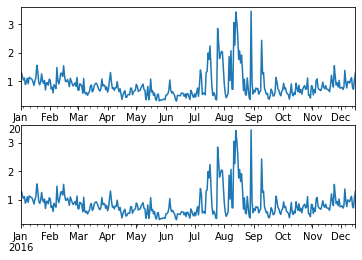

In [22]:
# Let's visualize these use and House overall to confirm they show the same data so that we could remove one of the columns
fig, axes = plt.subplots(nrows=2, ncols=1)
home_df['use'].resample('D').mean().plot(ax=axes[0])
home_df['House overall'].resample('D').mean().plot(ax=axes[1])

In [23]:
#Since the above plot confirms both the columns indicate the same data lets go ahead and remove 'House overall'
home_df = home_df.drop(columns=['House overall'])
home_df.shape

(503910, 25)

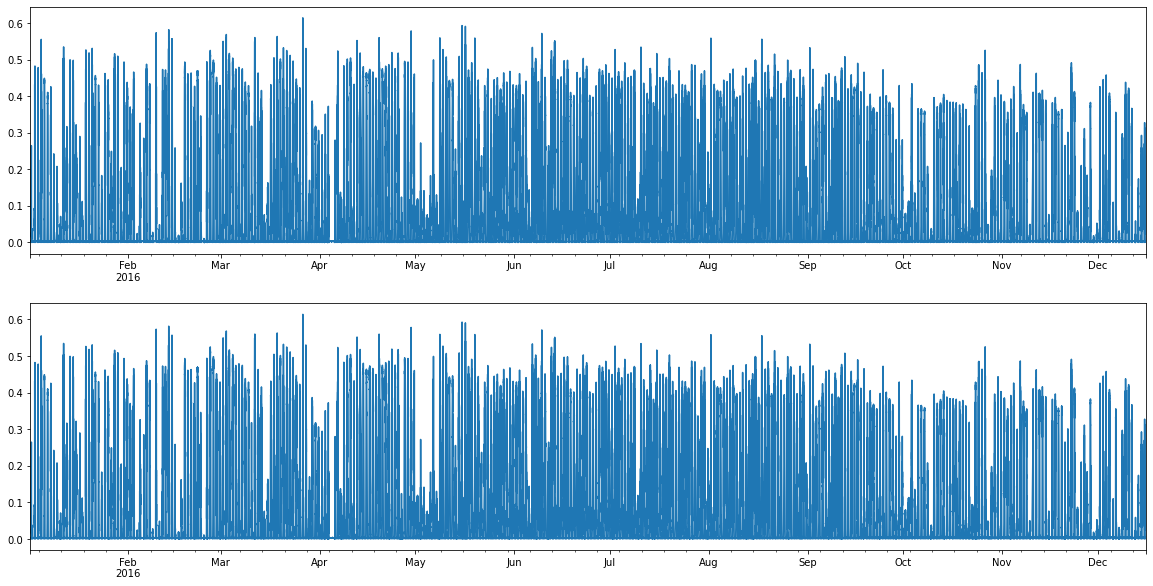

In [24]:
#Similarly, the attributes 'gen' and 'Solar' show the same data. Let's visualize these two columns to confirm the same
fig, axes = plt.subplots(nrows=2, ncols=1)
home_df['gen'].plot(ax=axes[0],figsize=(20,10))
home_df['Solar'].plot(ax=axes[1],figsize=(20,10))

In [25]:
#Dropping the column 'Solar' since it shows the same data as 'gen'
home_df = home_df.drop(columns=['Solar'])
home_df.shape

(503910, 24)

## Part 2 - Data Preparation

In [26]:
#Creating two separate dataframe objects with energy and weather data respectively.
energy_data = home_df.filter(items=[ 'gen', 'use', 'Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room'])

weather_data = home_df.filter(items=['temperature',
                                      'humidity', 'visibility', 'apparentTemperature', 'pressure',
                                      'windSpeed', 'windBearing', 'dewPoint'])

In [27]:
weather_data.head()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,dewPoint
2016-01-01 05:00:00,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:01:00,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:02:00,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:03:00,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:04:00,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4


## Part 3 - Data Visualization

In [28]:
#Generating the data per day
energy_per_day = energy_data.resample('D').sum()
energy_per_day.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-01,18.026200,1366.269517,59.517171,492.020017,64.668783,94.740300,29.093367,15.228367,3.873278,99.622950,30.537233,12.961117,77.071667
2016-01-02,76.051300,1851.521067,63.154404,683.761967,145.570317,74.851733,24.096767,19.246333,5.154752,185.776967,33.688133,12.480300,71.142950
2016-01-03,74.081433,1651.128133,105.508668,613.630533,196.064167,92.149033,32.989533,19.444933,6.364001,146.493667,31.955233,19.066117,42.779250
2016-01-04,108.525017,1500.686017,58.880760,605.129767,180.650867,71.016683,20.980700,19.249983,5.782085,47.837017,43.438883,20.249933,93.077467
2016-01-05,148.107500,1597.968867,72.973254,817.065250,133.360867,80.135633,30.792300,19.773067,4.918163,50.166067,19.157417,16.658967,44.483650


In [29]:
#Generating the data per week
energy_per_week = energy_data.resample('W').sum()
energy_per_week.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-03,168.158933,4868.918717,228.180243,1789.412517,406.303267,261.741067,86.179667,53.919633,15.392031,431.893583,96.180600,44.507533,190.993867
2016-01-10,572.221083,10281.065683,322.905918,4309.503517,1060.328917,595.732950,180.574800,139.934433,34.102771,691.477933,161.061051,104.610683,475.712567
2016-01-17,446.667833,10365.530000,415.871596,4661.908917,1036.034600,538.311483,201.654983,138.471933,34.200943,467.751483,165.124600,90.808833,446.148850
2016-01-24,773.163450,11446.274100,328.069396,5650.391533,845.905650,501.469017,177.311500,136.808333,35.232993,871.137733,173.225900,88.269900,431.383199
2016-01-31,636.354167,9294.364817,318.545145,3861.230900,695.367683,539.017367,195.041583,135.907333,35.082345,851.749650,170.518450,101.335400,376.918150


In [30]:
#Generating the data per month
energy_per_month = energy_data.resample('M').sum() 
energy_per_month.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-31,2596.565467,46256.153317,1613.572299,20272.447383,4043.940117,2436.271883,840.762533,605.041667,154.011083,3314.010383,766.110601,429.532350,1921.156633
2016-02-29,2704.221700,41558.035267,1399.090831,19171.333067,2850.642583,2225.080050,832.488483,572.159733,137.273728,2817.221550,741.079083,388.025434,1408.870900
2016-03-31,3795.807367,34026.880883,1506.501997,13046.526433,3511.736400,2393.101050,1268.479517,614.368167,134.469697,1791.915983,731.827333,426.910884,1585.980033
2016-04-30,3893.534950,29662.845900,1443.403725,9393.876000,3173.250717,2454.983017,1548.467600,627.425083,103.812260,2626.763767,658.356017,488.510350,1571.712033
2016-05-31,3670.712050,25550.843150,1180.812253,5957.877471,2768.990462,2648.659933,1561.469854,617.532683,99.109124,3321.740146,450.940233,406.917284,1179.055583


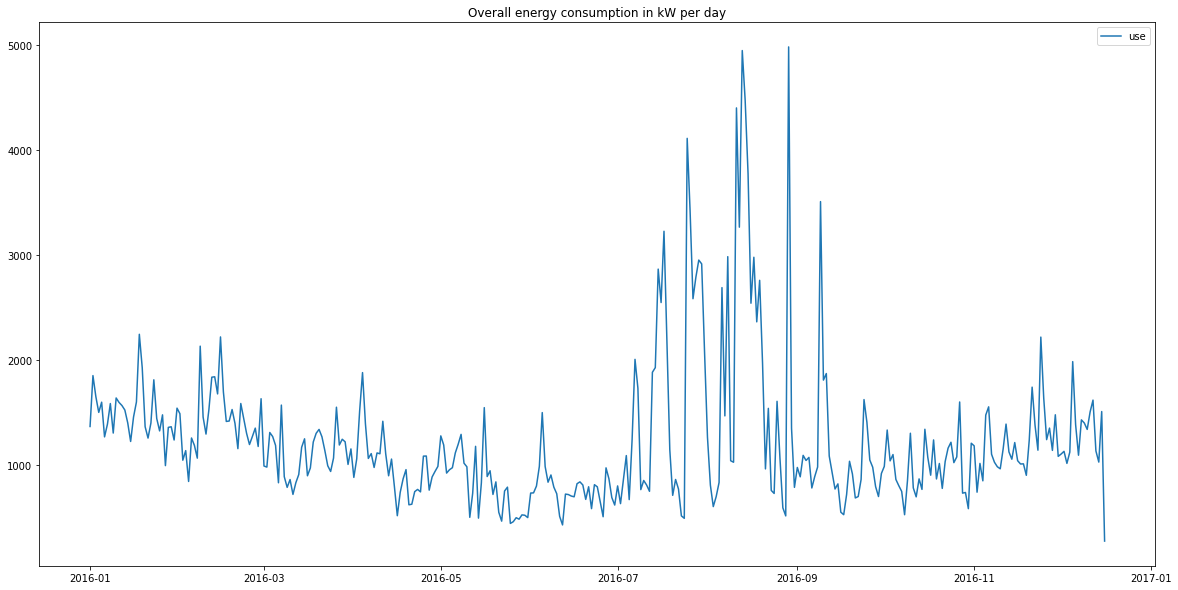

In [31]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per day")
#Plotting the energy consumption per day
sns.lineplot(data = energy_per_day.filter(items=['use']), dashes=False)

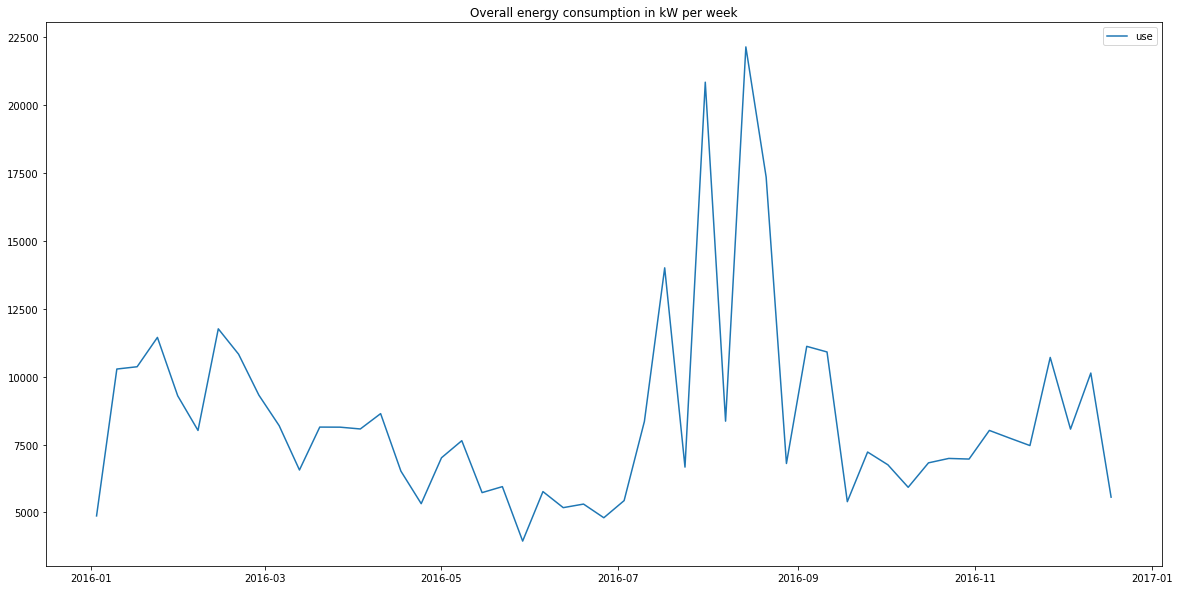

In [32]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per week")
#Plotting the energy consumption per week
sns.lineplot(data = energy_per_week.filter(items=['use']), dashes=False)

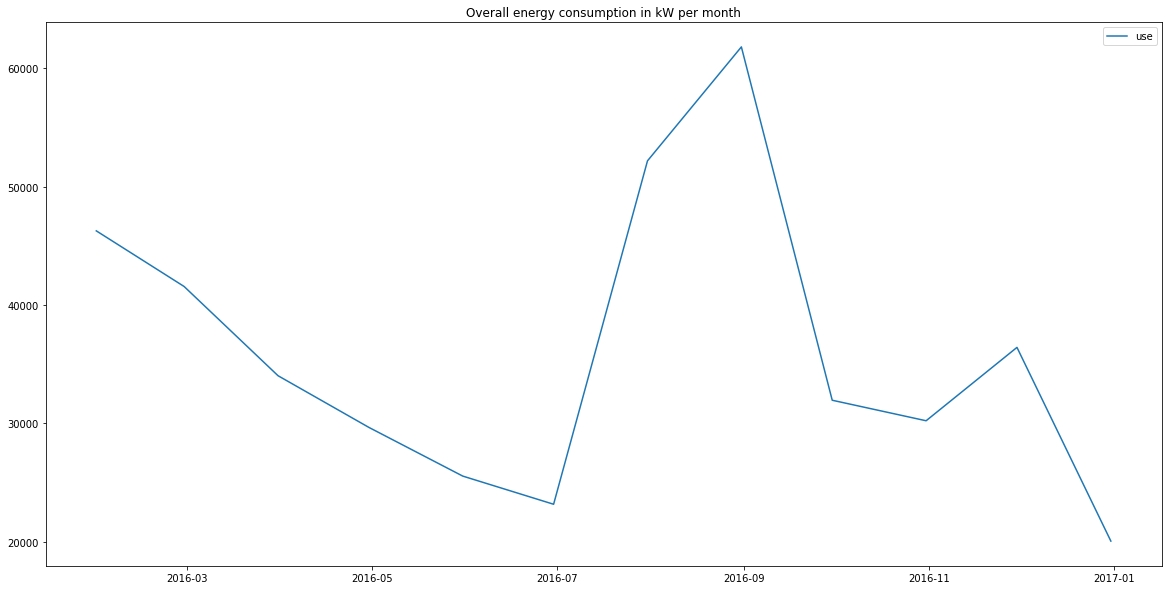

In [33]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per month")
#Plotting the energy consumption per month
sns.lineplot(data = energy_per_month.filter(items=['use']), dashes=False)

**August and September are the months with the highest energy consumption as per the above plot**

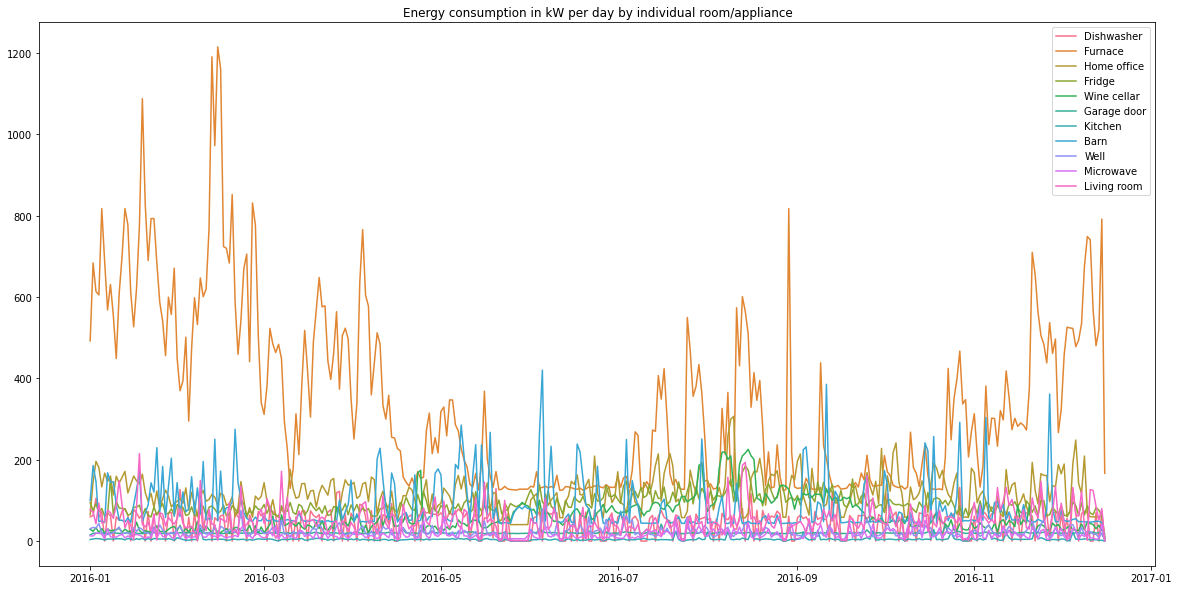

In [34]:
plt.figure(figsize=(20,10))
plt.title("Energy consumption in kW per day by individual room/appliance")
sns.lineplot(data = energy_per_day.filter(items=['Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room']), dashes=False)

**The above plot indicates that furnace has the highest energy consumption among the rooms/devices in the smart home in a day**

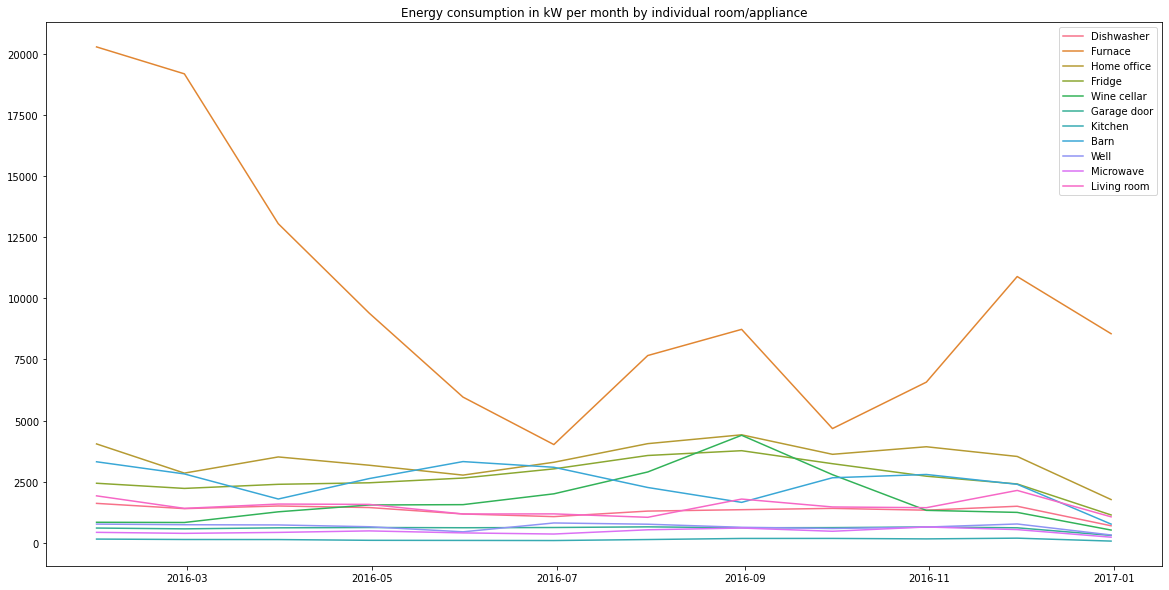

In [35]:
plt.figure(figsize=(20,10))
plt.title("Energy consumption in kW per month by individual room/appliance")
sns.lineplot(data = energy_per_month.filter(items=['Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room']), dashes=False)

**The above plot indicates that furnace has the highest energy consumption among the rooms/devices and Kitchen has the lowest in the smart home in a month.**

In [36]:
#Below we are splitting the energy consumption per month data into two sets. 

#1) Energy consumed by each room in the house
energy_per_room = energy_per_month.filter(items=['Home office',
                                     'Wine cellar', 'Kitchen','Barn',
                                      'Living room']) 

#2) Energy consumed by each device in the house
energy_per_device = energy_per_month.filter(items=[ 'Dishwasher',
                                     'Furnace','Fridge',
                                     'Garage door', 'Well',
                                     'Microwave'])

rooms_energy_consumption = energy_per_room.sum()
devices_energy_consumption = energy_per_device.sum()
print("Energy consumed in kW per month by each room in the house")
print(rooms_energy_consumption)
print("Energy consumed in kW per month by each device in the house")
print(devices_energy_consumption)

Energy consumed in kW per month by each room in the house
Home office    40961.277962
Wine cellar    21233.079320
Kitchen         1644.062194
Barn           29493.633696
Living room    17794.476716
dtype: float64
Energy consumed in kW per month by each device in the house
Dishwasher      15806.409510
Furnace        118917.457954
Fridge          32026.710600
Garage door      7124.847316
Well             7882.163852
Microwave        5534.440218
dtype: float64


****

Text(0.5, 1.0, 'Energy consumption in kW by each room in the house')

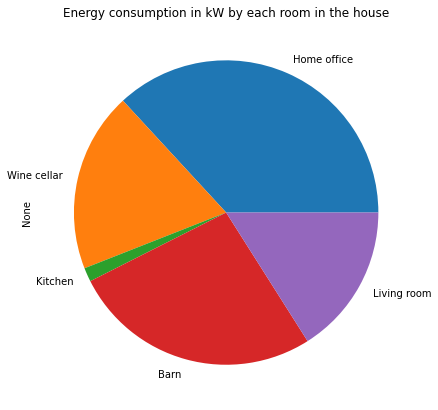

In [37]:
plot = rooms_energy_consumption .plot(kind = "pie", figsize = (7,7))
plot.set_title("Energy consumption in kW by each room in the house")

**Home office has the highest energy consumption and kitchen the lowest among all the rooms in the house.**

Text(0.5, 1.0, 'Energy consumption in kW by each device in the house')

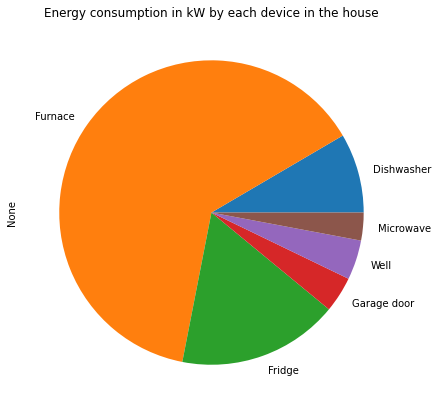

In [38]:
plot = devices_energy_consumption .plot(kind = "pie", figsize = (7,7))
plot.set_title("Energy consumption in kW by each device in the house")

**Furnace has the highest energy consumption and Microwave has the lowest among all the devices in the house.**

## Part 4 - Correlation between features

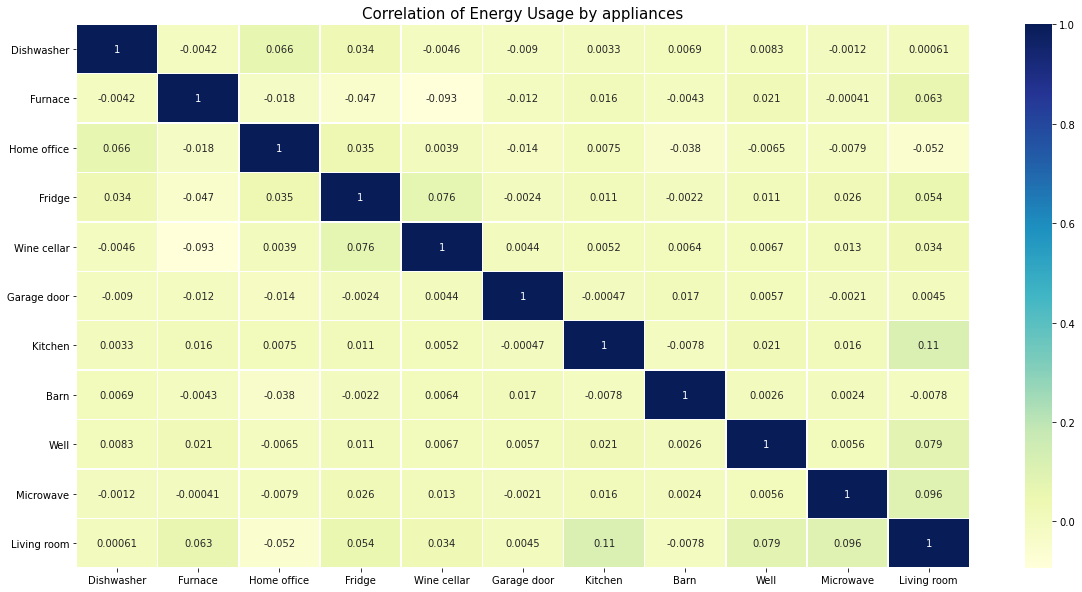

In [39]:
#Correlation of energy usage by home appliances

energy_corr = energy_data.loc[:,'Dishwasher':].corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(energy_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation of Energy Usage by appliances", size=15)
plt.show()

**No significant relationship between features, positive or negative, was observed. It is safe to presume that there is no interdependency between appliances when it comes to energy consumption.**

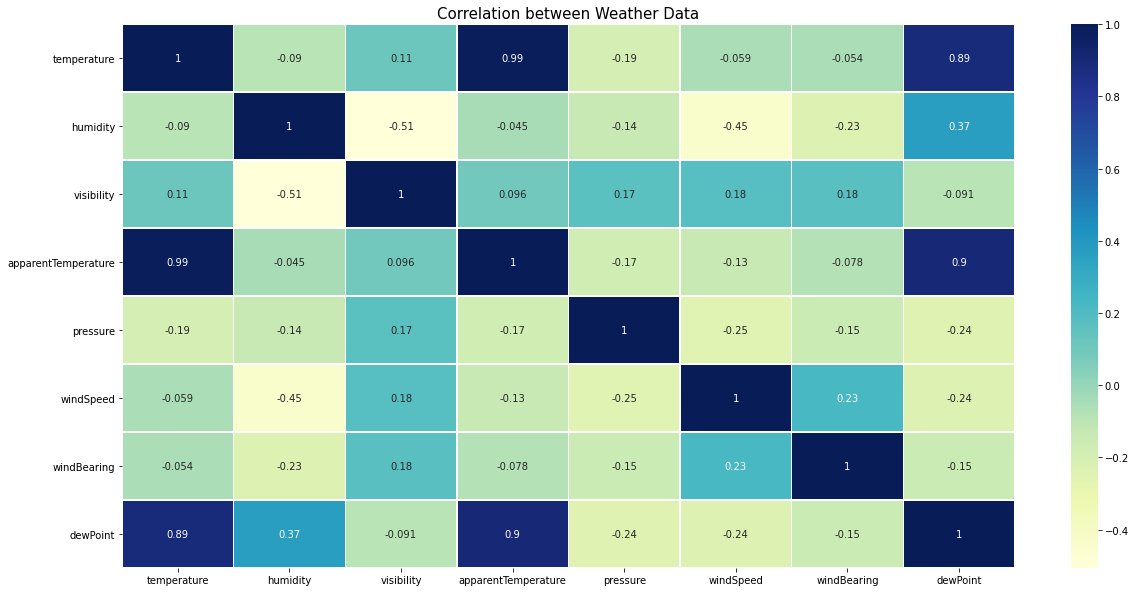

In [41]:
#Correlation between weather data

weather_corr = weather_data.corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(weather_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation between Weather Data", size=15)
plt.show()

**Strong positive correlation is observed here between some weather features:** 
**1. temperature and apparentTemperature (0.99)**
**2. temperature and dewPoint (0.89)**
**3. apparentTemperature and dewPoint (0.9)**

In [53]:
# Merge energy and weather datasets
allData_df = pd.merge(energy_data.loc[:,'Dishwasher':], weather_data, left_index=True, right_index=True)
allData_df.head()

,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,dewPoint
2016-01-01 05:00:00,0.000033,0.082617,0.442633,0.124150,0.006983,0.013083,0.000189,0.031350,0.001017,0.004067,0.001517,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:01:00,0.000000,0.084533,0.444067,0.124000,0.006983,0.013117,0.000189,0.031500,0.001017,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:02:00,0.000017,0.083017,0.446067,0.123533,0.006983,0.013083,0.000206,0.031517,0.001000,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:03:00,0.000017,0.175417,0.446583,0.123133,0.006983,0.013000,0.000217,0.031500,0.001017,0.004067,0.001617,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4
2016-01-01 05:04:00,0.000133,0.300917,0.446533,0.122850,0.006850,0.012783,0.000261,0.031500,0.001017,0.004067,0.001583,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,24.4


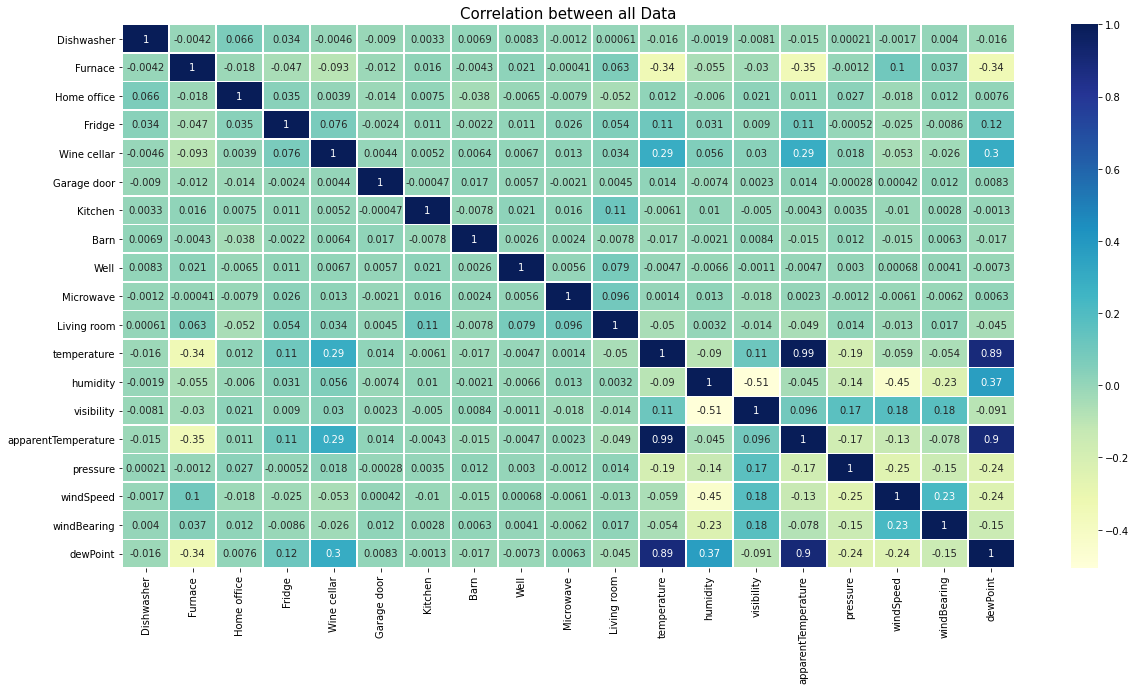

In [54]:
#Correlation between all data

all_corr = allData_df.corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(all_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation between all Data", size=15)
plt.show()

**Weak correlation between wine cellar and weather features like dewPoint(0.3), apparentTemperature(0.29) and temperature(0.29).
Relationships observed between other features as well, but not as significant.**

## Part 5 - Time Series Analysis

In [45]:
# define function to convert hour to time of day

def convertHourToPartOfDay(x):
    if x in [22,23,0,1,2,3]:
        part = 'Night'
    elif x in range(4, 12):
        part = 'Morning'
    elif x in range(12, 17):
        part = 'Afternoon'
    elif x in range(17, 22):
        part = 'Evening'
    else:
        part = 'X'
    return part

In [46]:
# define function to group by time of day

def groupByPartOfDay(column):
    partOfDayDf = energy_per_part_of_day.groupby('part').agg({column:['mean']})
    partOfDayDf.columns = [f"{i[0]}_{i[1]}" for i in partOfDayDf.columns]
    partOfDayDf['part_num'] = [['Morning','Afternoon','Evening','Night'].index(i) for i in partOfDayDf.index]
    partOfDayDf.sort_values('part_num', inplace=True)
    partOfDayDf.drop('part_num', axis=1, inplace=True)
    return partOfDayDf

In [47]:
# create column to indicate time of day in dataset

energy_per_part_of_day = energy_data.loc[:]
energy_per_part_of_day['hour'] = energy_per_part_of_day.index.map(lambda x: x.hour)
energy_per_part_of_day['part'] = energy_per_part_of_day['hour'].apply(convertHourToPartOfDay)

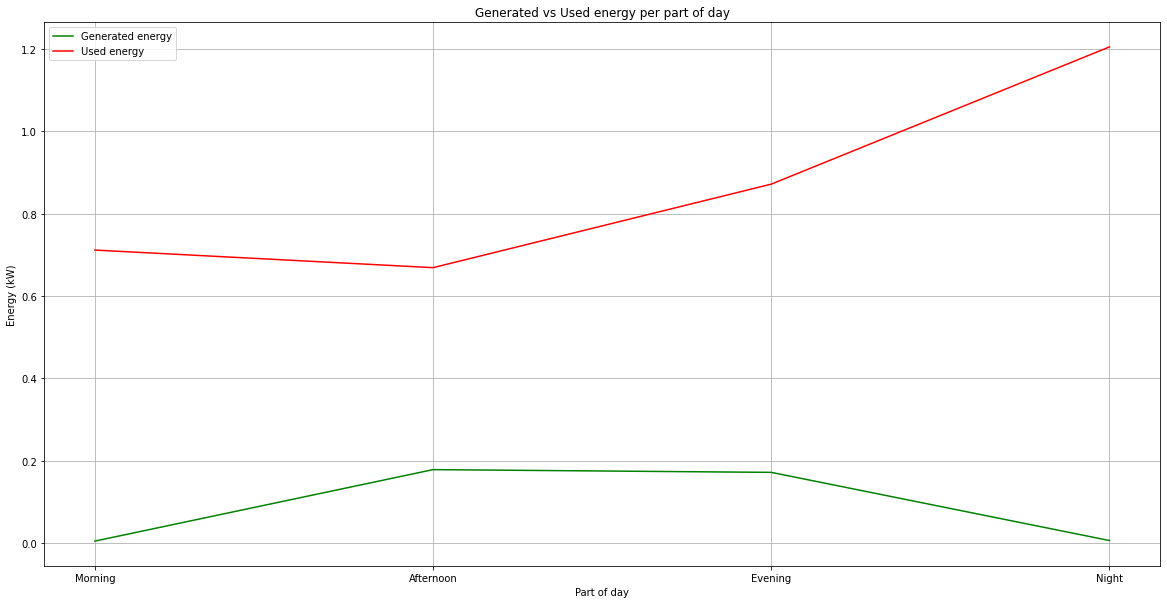

In [48]:
# Plot generated vs used energy per part of day

plt.figure(figsize=(20,10))
plt.plot(groupByPartOfDay('gen'), 'g', label='Generated energy')
plt.plot(groupByPartOfDay('use'), 'r', label='Used energy')
plt.title('Generated vs Used energy per part of day')
plt.ylabel('Energy (kW)')
plt.xlabel('Part of day')
plt.legend()
plt.grid(True)
plt.show()

**Highest energy usage is observed during evening and night. The energy generation is relatively higher during afternoon and evening.**

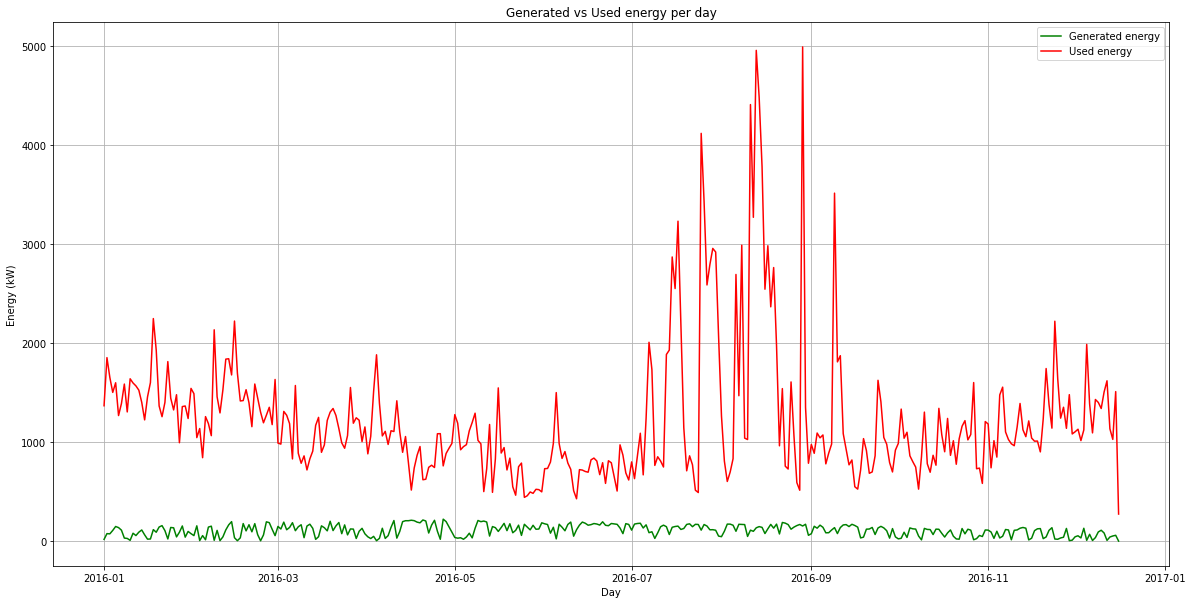

In [49]:
# Plot generated vs used energy per day

plt.figure(figsize=(20,10))
plt.plot(energy_per_day.gen, 'g', label='Generated energy')
plt.plot(energy_per_day.use, 'r', label='Used energy')
plt.title('Generated vs Used energy per day')
plt.ylabel('Energy (kW)')
plt.xlabel('Day')
plt.legend()
plt.grid(True)
plt.show()

**Highest energy usage is observed in the days between July and September. The energy generation is mostly consistent throughtout the year.**

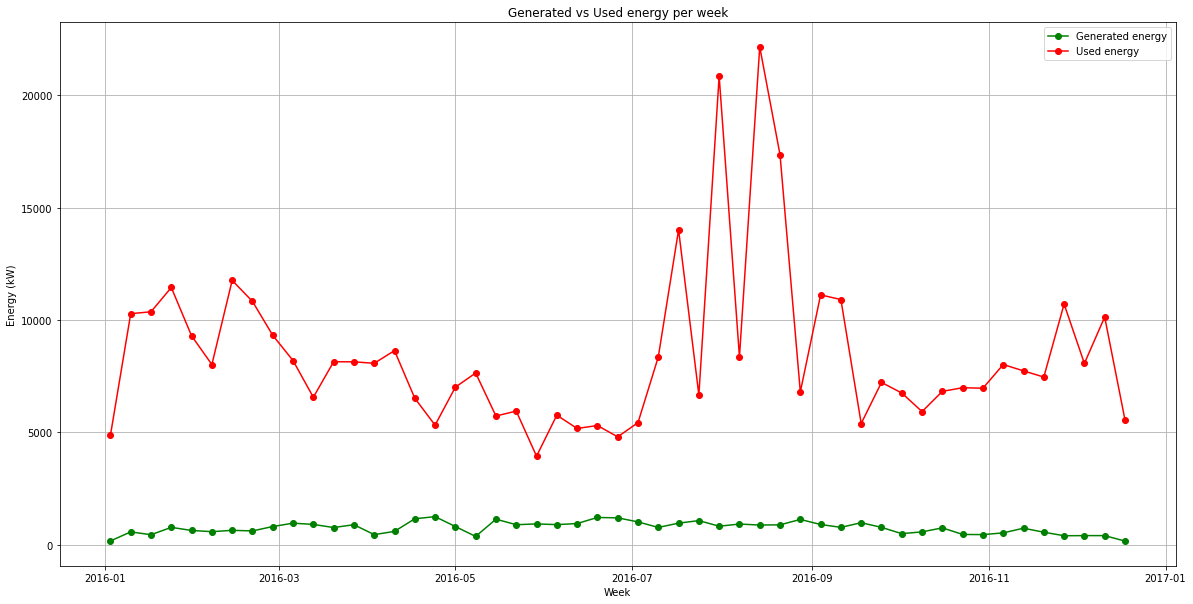

In [50]:
# Plot generated vs used energy per week

plt.figure(figsize=(20,10))
plt.plot(energy_per_week.gen, 'go-', label='Generated energy')
plt.plot(energy_per_week.use, 'ro-', label='Used energy')
plt.title('Generated vs Used energy per week')
plt.ylabel('Energy (kW)')
plt.xlabel('Week')
plt.grid(True)
plt.legend()
plt.show()

**Highest energy usage is observed in the weeks between July and September. The energy generation is slightly high in the weeks between April and May but mostly consistent.**

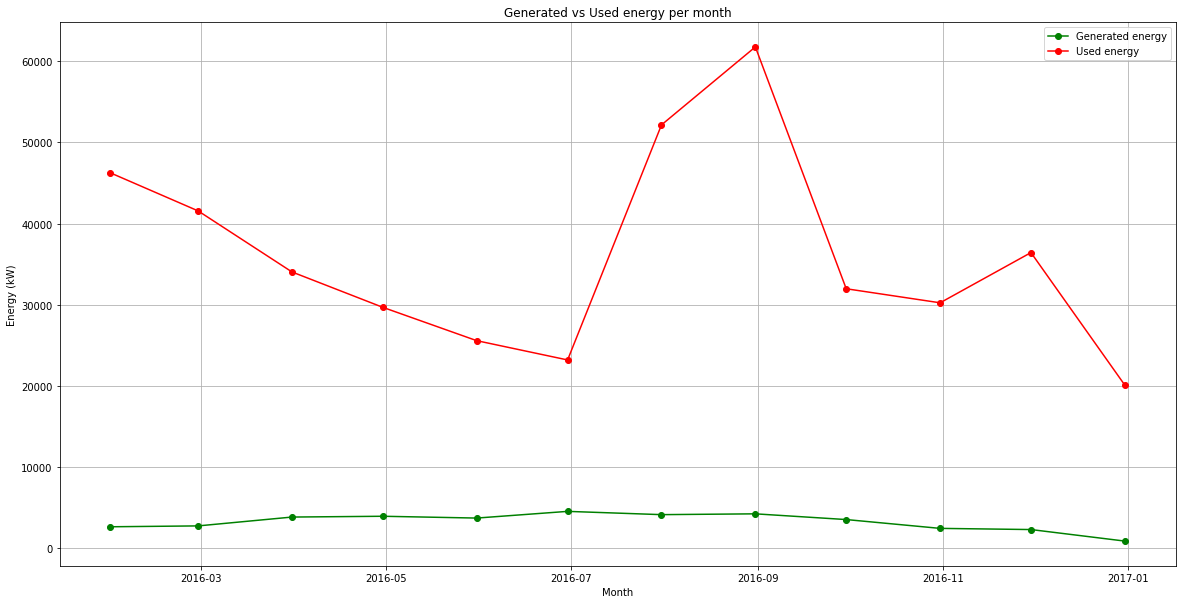

In [51]:
# Plot generated vs used energy per month

plt.figure(figsize=(20,10))
plt.plot(energy_per_month.gen, 'go-', label='Generated energy')
plt.plot(energy_per_month.use, 'ro-', label='Used energy')
plt.title('Generated vs Used energy per month')
plt.ylabel('Energy (kW)')
plt.xlabel('Month')
plt.grid(True)
plt.legend()
plt.show()

**Highest energy usage is observed in the month of September. Months like August, February, March, April and December show high usage as well. The energy generation is slightly high in the month of July but mostly consistent.**

## 3 main factors of Time-Series Analysis:
### 1. Autocorrelation
### 2. Seasonality
### 3. Stationarity

**1. Autocorrelation**

Autocorrelation for 'gen' =  0.41241766211014136


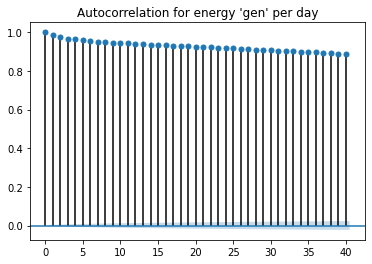

In [ ]:
#Plot ACF for energy 'gen'

print("Autocorrelation for 'gen' = ", energy_per_day['gen'].autocorr())
fig = plot_acf(energy_data['gen'], lags=40, title="Autocorrelation for energy 'gen' per day")
plt.show()

**Data has positive autocorrelation. It provides good predictability with autocorrelation value = 0.41.**

Autocorrelation for 'use' =  0.6107009825029095


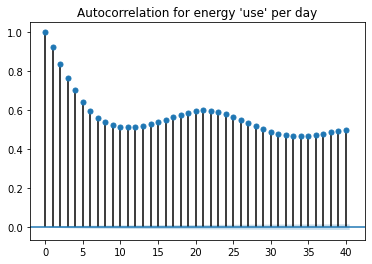

In [ ]:
#Plot ACF for energy 'use'

print("Autocorrelation for 'use' = ", energy_per_day['use'].autocorr())
fig = plot_acf(energy_data['use'], lags=40, title="Autocorrelation for energy 'use' per day")
plt.show()

**Data has positive autocorrelation. It provides good predictability with autocorrelation value = 0.61.**

**2. Seasonality**

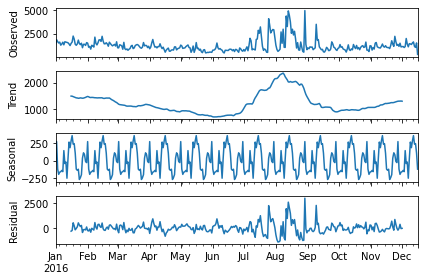

In [ ]:
#Seasonal decomposition is performed on the dataset to see if there is seasonality displayed in the per-day dataset at a frequency of 30 days(monthly)

result = seasonal_decompose(energy_per_day['use'], model='additive', freq=30)
result.plot()
plt.show()

**It is observed in the figure above that the per-day dataset displays a seasonal behavior at a frequency of 30**

**3. Stationarity**

In [98]:
# split the dataset into two, and calculate mean and variance for both subsets

X = energy_data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.113294, mean2=0.121690
variance1=0.092859, variance2=0.212700


**The dataset is splitted into two contiguous halves. Mean and variance is calculated for each subset. There is a little difference observed but it can be concluded that the values are essentially in the same ballpark.**

## Part 6 - Anomaly Detection


In [52]:
# Distribution of generated energy per day
data = energy_per_day.filter(items=['gen'])
df["gen"] = data
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Day')
plt.show();

NameError: ignored

In [ ]:
# Distribution of generated energy per week
data = energy_per_week.filter(items=['gen'])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Week')
plt.show();

In [ ]:
# Distribution of generated energy per month
data = energy_per_month.filter(items=['gen'])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Month')
plt.show();

In [ ]:
# Distribution of use energy per day
data = energy_per_day.filter(items=['use'])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Day')
plt.show();

In [ ]:
# Distribution of use energy per week
data = energy_per_week.filter(items=['use'])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Day')
plt.show();

In [ ]:
# Distribution of use energy per month
data = energy_per_month.filter(items=['use'])
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Day')
plt.show();

**Multivariate Anomaly Detection**

In [ ]:
# Generated vs Used Energy per day 
sns.regplot(x="gen", y="use", data=energy_per_day)
sns.despine();

In [ ]:
# Generated vs Used Energy per week 
sns.regplot(x="gen", y="use", data=energy_per_week)
sns.despine();

In [ ]:
# Generated vs Used Energy per month 
sns.regplot(x="gen", y="use", data=energy_per_month)
sns.despine();

## Part 7 - Time Series Forecasting using ARIMA model

In [ ]:
#Autocorrelation plot is used to find the AR parameter p of the ARIMA model
corr_df= home_df[0:50]
autocorrelation_plot(corr_df['use'])
plt.show()

**As shown in the above plot it is somewhere around 3 or 4 that the plot is entering the critical boundary and hence for our ARIMA model lets choose the P value as 3**

In [ ]:
plot_pacf(corr_df['use'], lags=20)

**PACF plot cuts of quickly at 1 or 2**

In [ ]:
#We initially trained the model on a resampled dataset with 20,000 records but since it takes a
#lot of time in the order of several hours depending on the p,d,q combinations of ARIMA we have 
#resampled the data with just 2000 records for the convenience of reducing the time of execution 
home_arima_df= home_df[0:3000]

**We experimented with different p and q values keeping d=1 for the ARIMA model and found that we get the least value for MSE with p=3, d=1 and q=1. But keeping the value q=1 was taking too long to train the data(more than two hours) with 20,000 records where as with q=0 we were able to train the model just under one hour(3571.43seconds) as indicated in the screenshot.**

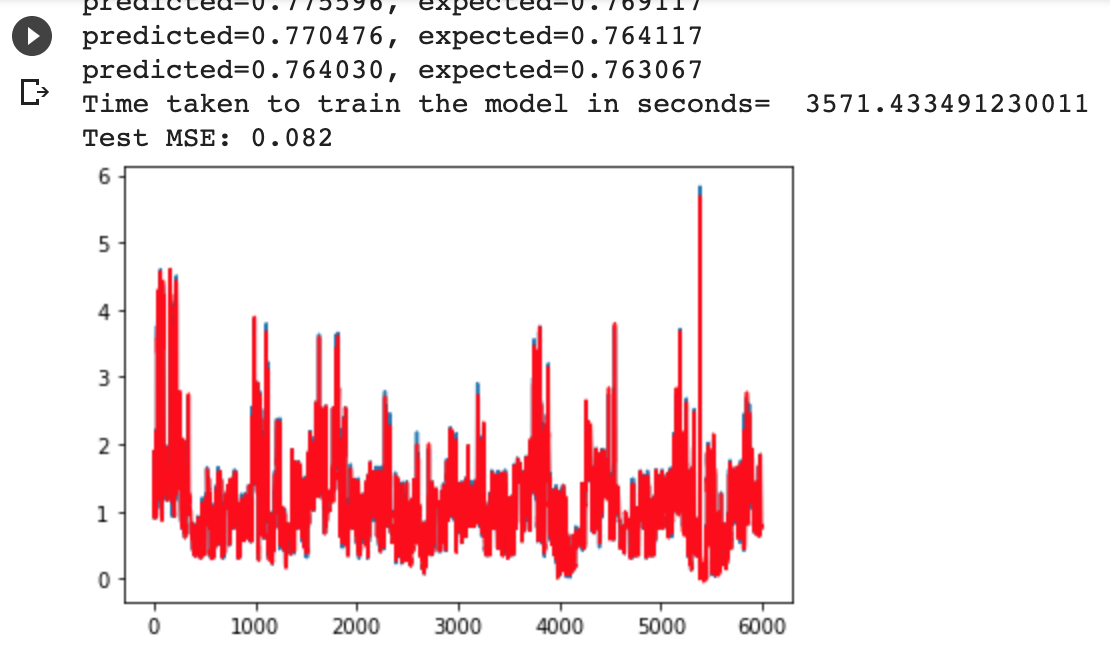

**Training an ARIMA model**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import time
 
def forecast_timeseries(p,d,q):
    X = home_arima_df['use'].values
    size = int(len(X) * 0.70)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    start_time= time.time()
    for t in range(len(test)):
        
    
    	model = ARIMA(history, order=(p,d,q))
    	model_fit = model.fit(disp=0)
    	output = model_fit.forecast()
    	yhat = output[0]
    	predictions.append(yhat)
    	obs = test[t]
    	history.append(obs)
    	print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    end_time= time.time()
    time_taken= end_time-start_time
    print('Time taken to train the model in seconds= ',time_taken)
    print('Test MSE: %.3f' % error)
# plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

In [ ]:
#Passing the p,d,q parameters for the ARIMA model
forecast_timeseries(3,0,2)

**Residual Analysis of the ARIMA model**

In [ ]:
from pandas import DataFrame
#We get the information if the model is accurate from the residual analysis
residuals= DataFrame(model_fit.resid)
residuals.plot()

**There is no visible trend or pattern in the residuals plot which indicates our model is accurate**

In [ ]:
residuals.describe()

**The mean is centered around zero which indicates our model is accurate**

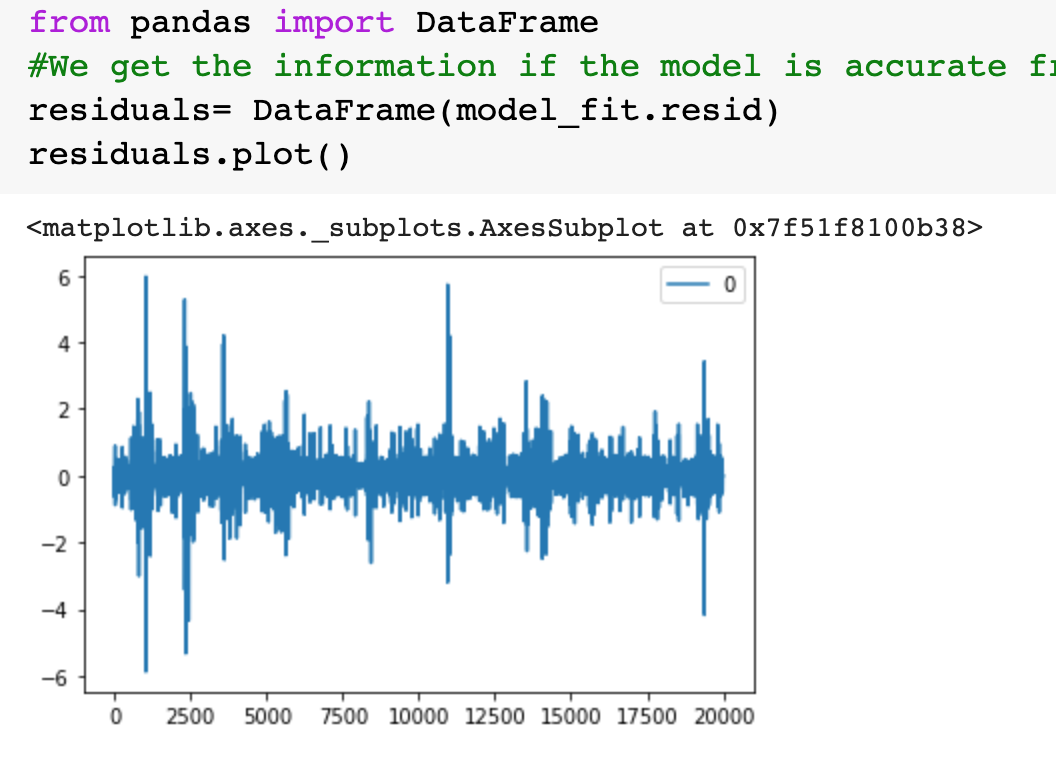

**Above is the residual plot for the model trained on 20,000 records with the parameter values p=3, d=1 and q=0. It clearly indicates there is no visible trend or pattern in the plot and hence no correlation between the residuals which indicates our model is accurate.**

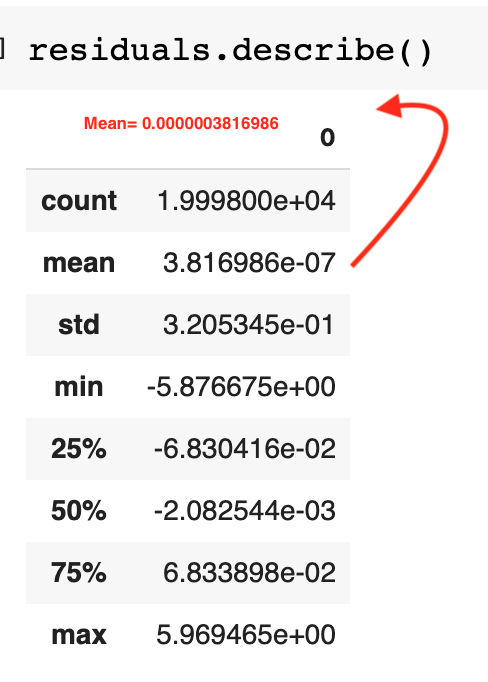

**The mean of the residuals is centered around 0 (3.816986e-07 = 0.0000003816986) for the model trained on 20,000 records which indicates our model is accurate**